### Baseline Model

Solution currently used by the bank

We test four binary classification DM models: logistic regression (LR), decision
trees (DTs), neural network (NN) and support vector machine (SVM).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, average_precision_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.utils.fixes import signature
pd.options.display.float_format = '{:.2f}'.format

In [3]:
#Loading df1:
df = pd.read_pickle('data/pickle_files/df_pickle')

In [4]:
#Checking dtypes have loaded correctly (should return empty index)
df.select_dtypes(exclude = ['float64', 'int64']).columns

y = df['y']
X = df.drop(columns=['y'])

In [5]:
scaler = preprocessing.StandardScaler().fit(X)
X_transformed = scaler.transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_transformed), y, random_state = 4)

In [7]:
for c in [0.000001, 0.00001, 0.0001, 0.1, 1]:
    regressor = LogisticRegression(C = c)
    regressor.fit(X_train, y_train)
    print("Logistic Regression with C = {:.6f}".format(c))
    print("Training Accuracy: {}".format(regressor.score(X_train, y_train)))
    print("Test Accuracy: {}".format(regressor.score(X_test, y_test)))
    print("----")

Logistic Regression with C = 0.000001
Training Accuracy: 0.8528697678935613
Test Accuracy: 0.8506361076041565
----
Logistic Regression with C = 0.000010
Training Accuracy: 0.8829756239681461
Test Accuracy: 0.8824900456443624
----
Logistic Regression with C = 0.000100
Training Accuracy: 0.9053122268621929
Test Accuracy: 0.9023987569194911
----
Logistic Regression with C = 0.100000
Training Accuracy: 0.9118837201773979
Test Accuracy: 0.9090026221229485
----
Logistic Regression with C = 1.000000
Training Accuracy: 0.9112039105241009
Test Accuracy: 0.9084199281344081
----


Baseline model with Cross Validation

In [8]:
clf = LogisticRegressionCV(cv=5, Cs = [10**i for i in range(-2,2)],
                           penalty = 'l2', random_state=0, 
                           scoring = 'accuracy',#,'precision','recall'],
                           multi_class='ovr').fit(X_train, y_train)

print(clf.get_params)
print('\n')
print("Prediction %s on Test Set: %.6f" %(clf.scoring, clf.score(X_test, y_test)))

<bound method BaseEstimator.get_params of LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=0, refit=True, scoring='accuracy', solver='lbfgs',
           tol=0.0001, verbose=0)>


Prediction accuracy on Test Set: 0.909100


In [9]:
def print_scores(clf, X_test):
    y_pred = clf.predict(X_test)
    print("Scores on Test Dataset")
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    print("Recall Score: ", recall_score(y_test, y_pred))
    print("Precision Score: ", precision_score(y_test, y_pred))

##### Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances. 

##### Recall (also known as sensitivity) is the fraction of relevant instances that have been retrieved over the total amount of relevant instances.

Precision can be seen as a measure of exactness or quality, whereas recall is a measure of completeness or quantity.

Precision = TP/(TP+FP) ---- Recall = TP/(TP+FN)

In [10]:
print_scores(clf, X_test)

Scores on Test Dataset
Accuracy Score:  0.9090997377877051
Recall Score:  0.39708404802744424
Precision Score:  0.6652298850574713


While accuracy seems high, we have quite a lot of false negatives i.e. labels we have misclassified as negative leading to a potential loss in revenue.
We need higher recall, which might come at the cost of having lower precision but that's ok - we'd rather detect more real customers even if that means overguessing at times

In [11]:
def make_conf_matrix(clf, X_test):
    y_pred = clf.predict(X_test)
    cmx = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                   index = ['No', 'Yes'],
                   columns = ['No', 'Yes'])
    return cmx

In [12]:
def plot_conf_matrix(cmx):
    cmap = mpl.colors.ListedColormap(['green'])
    cmap1 = mpl.colors.ListedColormap(['red'])
    mask1 = (cmx.isin([cmx.iloc[0,0],cmx.iloc[1,1]]))
    
    f, ax = plt.subplots(figsize = (9,6))
    sns.heatmap(cmx, annot=True, fmt = 'g', cmap = cmap,
            cbar = False, annot_kws={"size": 20},
            ax=ax)
    sns.heatmap(cmx, mask=mask1 , cmap=cmap1, cbar=False)

    ax.set_ylabel('True label', fontsize = 15)
    ax.set_xlabel('Predicted label', fontsize = 15)
    ax.set_title("Confusion Matrix", fontsize = 20)
    plt.show()

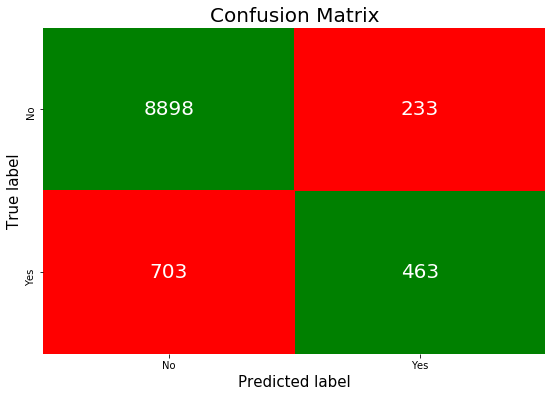

In [13]:
#Creating Confusion Matrix for Dirty Model:
cmx = make_conf_matrix(clf, X_test)
plot_conf_matrix(cmx)

In [14]:
#Sanity Check - verifying results 
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
#the results are correct

8898 233 703 463


##### We have 703 false negatives. This means we have 703 customers we are misclassifying as uninterested! In comparison with only 463 customers who are correctly classified as interested for a total of 1166 True Positives (sum across second row). We must try to move customers from the bottom left to the bottom right quadrants

We want to increase the True Positive Rate = True Positives / (True Positives + False Negatives)
The true positive rate is known as Recall or Sensitivity.

In [41]:
y_pred = clf.predict_proba(X_test)

In [42]:
pd.DataFrame(y_pred).head()

,0,1
0,0.78,0.22
1,0.92,0.08
2,0.97,0.03
3,0.97,0.03
4,0.93,0.07


In [48]:
#pd.DataFrame(y_pred).T.plot(kind='scatter')

In [18]:
def plot_precision_recall(clf, X_test):
    
    y_pred = clf.predict(X_test)
    
    p = np.linspace(10,100,len(y_pred))
    
    precision, recall, thresholds = precision_recall_curve(y_test, probas_pred=p)
    average_precision = average_precision_score(y_test, y_pred)
    
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

Average precision-recall score: 0.33


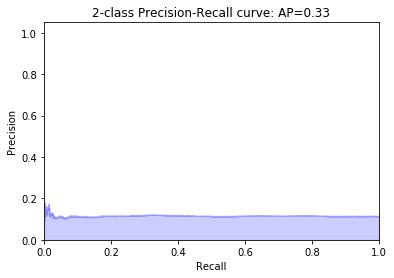

In [19]:
plot_precision_recall(clf, X_test)

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:
where  and  are the precision and recall at the nth threshold

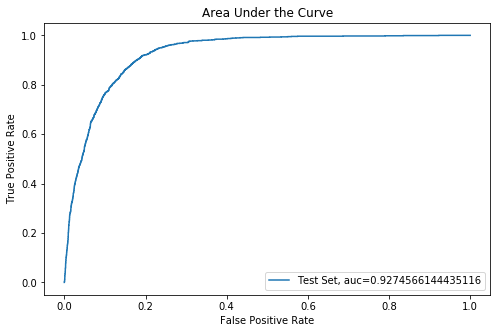

In [20]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize = (8,5))
plt.plot(fpr,tpr,label="Test Set, auc="+str(auc))
plt.title("Area Under the Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

In [21]:
#StratifiedKFold is a variation of k-fold which returns stratified folds: 
#each set contains approximately the same percentage 
#of samples of each target class as the complete set.
skf = StratifiedKFold(n_splits=5, random_state = 0)
scores = []

In [22]:
def print_foldscore(X, y, kfold_obj, c):
    
    for k, (train, test) in enumerate(kfold_obj.split(X, y)):
        regressor = LogisticRegression(C = c, multi_class = 'ovr')
        regressor.fit(X.iloc[train], y.iloc[train])
        print("[fold {0}] C: {1:.5f}, score: {2:.5f}".format(k, regressor.C, regressor.score(X.iloc[test], y.iloc[test])))
        scores.append(regressor.score(X.iloc[test], y.iloc[test]))

In [23]:
for c in [10**i for i in range(-2,2)]:
    print("Value for C parameter: ", c)
    print_foldscore(X_train, y_train, skf, c)
    print("----")

Value for C parameter:  0.01
[fold 0] C: 0.01000, score: 0.90986
[fold 1] C: 0.01000, score: 0.91050
[fold 2] C: 0.01000, score: 0.90919
[fold 3] C: 0.01000, score: 0.91664
[fold 4] C: 0.01000, score: 0.91015
----
Value for C parameter:  0.1
[fold 0] C: 0.10000, score: 0.90986
[fold 1] C: 0.10000, score: 0.91180
[fold 2] C: 0.10000, score: 0.91065
[fold 3] C: 0.10000, score: 0.91761
[fold 4] C: 0.10000, score: 0.90886
----
Value for C parameter:  1
[fold 0] C: 1.00000, score: 0.90856
[fold 1] C: 1.00000, score: 0.91180
[fold 2] C: 1.00000, score: 0.91049
[fold 3] C: 1.00000, score: 0.91664
[fold 4] C: 1.00000, score: 0.90821
----
Value for C parameter:  10
[fold 0] C: 10.00000, score: 0.90808
[fold 1] C: 10.00000, score: 0.91131
[fold 2] C: 10.00000, score: 0.91049
[fold 3] C: 10.00000, score: 0.91648
[fold 4] C: 10.00000, score: 0.90821
----


#### Optimization Algorithms Available (Solver Parameter)

- LIBLINEAR – A Library for Large Linear Classification
https://www.csie.ntu.edu.tw/~cjlin/liblinear/

- SAG – Mark Schmidt, Nicolas Le Roux, and Francis Bach
Minimizing Finite Sums with the Stochastic Average Gradient https://hal.inria.fr/hal-00860051/document

- SAGA – Defazio, A., Bach F. & Lacoste-Julien S. (2014).
SAGA: A Fast Incremental Gradient Method With Support for Non-Strongly Convex Composite Objectives https://arxiv.org/abs/1407.0202

- Hsiang-Fu Yu, Fang-Lan Huang, Chih-Jen Lin (2011). Dual coordinate descent
methods for logistic regression and maximum entropy models. Machine Learning 85(1-2):41-75. https://www.csie.ntu.edu.tw/~cjlin/papers/maxent_dual.pdf

In [24]:
np.array([10**i for i in range(-2,2)])

array([ 0.01,  0.1 ,  1.  , 10.  ])

In [25]:
def search_hyper(parameters, clf = LogisticRegressionCV(cv=5, random_state=0, Cs = np.logspace(-2, 3, num=6, base=10))):
    gs = GridSearchCV(clf, parameters, cv = 3).fit(X_train, y_train)
    print('Best Estimator: ')
    gs.best_estimator_
    print('----')
    print_scores(gs.best_estimator_, X_test)
    return gs.best_estimator_

In [26]:
parameters_1 = {'solver':['lbfgs', 'liblinear'],
              'max_iter': [10,20,30], 
              'class_weight': ['balanced'],
              'scoring':['accuracy']}

In [27]:
parameters_2 = {'solver':['lbfgs', 'liblinear'],
              'max_iter': [10,20,30],
              'class_weight': ['balanced'],
              'scoring':['recall']}

In [28]:
parameters_3 = {'solver':['lbfgs', 'liblinear'],
              'max_iter': [10,20,30],
              'class_weight': ['None'],
              'scoring':['recall']}

In [29]:
parameters_4 = {'solver':['lbfgs', 'liblinear'],
              'max_iter': [60,70,80],
              'class_weight': ['None'],
              'scoring':['recall']}

In [30]:
search_hyper(parameters_1)

Best Estimator: 
----
Scores on Test Dataset
Accuracy Score:  0.8552976595124794
Recall Score:  0.8704974271012007
Precision Score:  0.4311809685641461


LogisticRegressionCV(Cs=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
           class_weight='balanced', cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=10, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, refit=True, scoring='accuracy',
           solver='lbfgs', tol=0.0001, verbose=0)

In [31]:
search_hyper(parameters_2)

Best Estimator: 
----
Scores on Test Dataset
Accuracy Score:  0.8552976595124794
Recall Score:  0.8704974271012007
Precision Score:  0.4311809685641461


LogisticRegressionCV(Cs=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
           class_weight='balanced', cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=10, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, refit=True, scoring='recall',
           solver='lbfgs', tol=0.0001, verbose=0)

In [32]:
search_hyper(parameters_3)

Best Estimator: 
----
Scores on Test Dataset
Accuracy Score:  0.9089055064581917
Recall Score:  0.39622641509433965
Precision Score:  0.6637931034482759


LogisticRegressionCV(Cs=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
           class_weight='None', cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=10, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, refit=True, scoring='recall',
           solver='lbfgs', tol=0.0001, verbose=0)

In [33]:
search_hyper(parameters_4)

Best Estimator: 
----
Scores on Test Dataset
Accuracy Score:  0.9090026221229485
Recall Score:  0.3979416809605489
Precision Score:  0.6638054363376252


LogisticRegressionCV(Cs=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
           class_weight='None', cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=60, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, refit=True, scoring='recall',
           solver='liblinear', tol=0.0001, verbose=0)

Best Estimator: 
----
Scores on Test Dataset
Accuracy Score:  0.8552976595124794
Recall Score:  0.8704974271012007
Precision Score:  0.4311809685641461
Average precision-recall score: 0.39


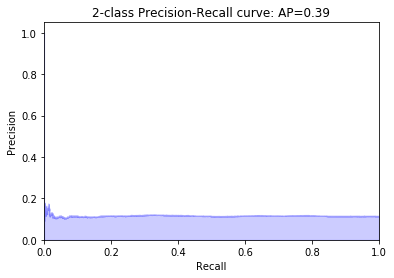

In [34]:
clf = search_hyper(parameters_2)
plot_precision_recall(clf, X_test)

Balanced classes are definitely helping out a lot! Let's continue with different parameters

Let's try both l1 and l2 regularization

In [35]:
parameters_5 = {'solver':['saga'],
              'max_iter': [100], 
              'class_weight': ['balanced'],
              'scoring':['accuracy'],
              'penalty':['l1', 'l2']}

Best Estimator: 
----
Scores on Test Dataset
Accuracy Score:  0.8552976595124794
Recall Score:  0.8704974271012007
Precision Score:  0.4311809685641461
Average precision-recall score: 0.39


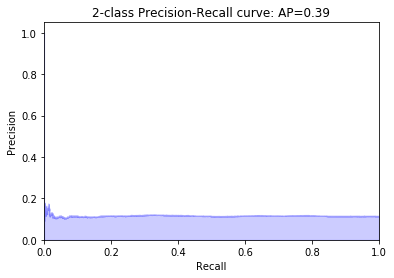

In [36]:
clf = search_hyper(parameters_5)
plot_precision_recall(clf, X_test)

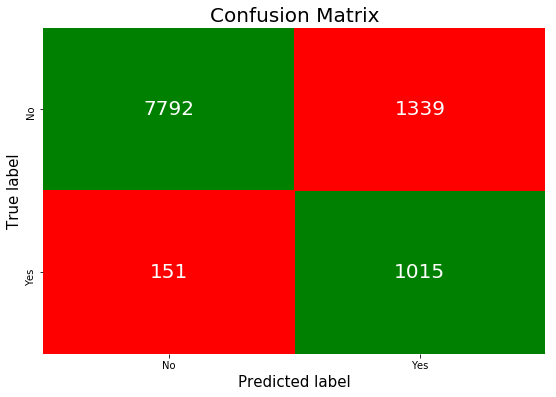

In [37]:
cmx = make_conf_matrix(clf, X_test)
plot_conf_matrix(cmx)

We have managed to greatly improve our recall, but more can be done!

In [38]:
pred_proba_df = pd.DataFrame(clf.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]

In [39]:
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    
    test_accuracy = accuracy_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
        Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our Test Set Accuracy is {}'.format(test_accuracy))

    test_recall = recall_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
        Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our Test Set Recall Score is {}'.format(test_recall))

    test_precision = precision_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
        Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our Test Set Precision Score is {}'.format(test_precision))
    
    print(confusion_matrix(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
        Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1)))


******** For i = 0.05 ******
Our Test Set Accuracy is 0.42303583568029524
Our Test Set Recall Score is 0.9974271012006861
Our Test Set Precision Score is 0.16377974933108014
[[3193 5938]
 [   3 1163]]

******** For i = 0.1 ******
Our Test Set Accuracy is 0.6054190540934252
Our Test Set Recall Score is 0.9948542024013722
Our Test Set Precision Score is 0.22235000958405213
[[5074 4057]
 [   6 1160]]

******** For i = 0.15 ******


/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values 

Our Test Set Accuracy is 0.681169272603671
Our Test Set Recall Score is 0.9879931389365352
Our Test Set Precision Score is 0.2605745306491744
[[5862 3269]
 [  14 1152]]

******** For i = 0.2 ******
Our Test Set Accuracy is 0.7276876760221423
Our Test Set Recall Score is 0.9802744425385935
Our Test Set Precision Score is 0.29128440366972475
[[6350 2781]
 [  23 1143]]

******** For i = 0.25 ******
Our Test Set Accuracy is 0.7639118189764009
Our Test Set Recall Score is 0.9682675814751286
Our Test Set Precision Score is 0.32046551234743115
[[6737 2394]
 [  37 1129]]

******** For i = 0.3 ******
Our Test Set Accuracy is 0.7897445858016898
Our Test Set Recall Score is 0.9562607204116638
Our Test Set Precision Score is 0.34530814493651285
[[7017 2114]
 [  51 1115]]

******** For i = 0.35 ******
Our Test Set Accuracy is 0.8108186850538992
Our Test Set Recall Score is 0.9425385934819898
Our Test Set Precision Score is 0.3687919463087248
[[7250 1881]
 [  67 1099]]

******** For i = 0.4 ******
O